In [ ]:
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 128
LEARNING_RATE = 0.0001
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9
EPOCHS = 200
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.0
ADAM_BETA_2 = 0.9

In [ ]:
import pandas as pd
import keras as keras
from tensorflow import keras
from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Dense , Flatten, UpSampling2D, Conv2D, Dropout, LeakyReLU
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.datasets import fashion_mnist
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import os
import re
import warnings
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.src import backend
from keras.src.api_export import keras_export
from keras.src.callbacks.callback import Callback
from keras.src.utils import file_utils
from keras.src.utils import io_utils
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.preprocessing.image import img_to_array
from PIL import Image
import numpy as np
!pip install -q kaggle

In [ ]:
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import Callback

In [ ]:
#import shutil
#import os

# Ruta del directorio a eliminar
#folder_path = '/content/dog_breed_data'

# Verificar si el directorio existe
#if os.path.exists(folder_path):
#    shutil.rmtree(folder_path)
#    print(f"El directorio '{folder_path}' y todo su contenido han sido eliminados.")
#else:
#    print(f"El directorio '{folder_path}' no existe.")


In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle
!kaggle competitions download -c dog-breed-identification
!unzip -q dog-breed-identification.zip -d dog_breed_data

Saving kaggle.json to kaggle.json
ca156ac0eda802b32f672754939a5966
ca156ac0eda802b32f672754939a5966
ca156ac0eda802b32f672754939a5966
 96% 661M/691M [00:00<00:00, 1.33GB/s]
100% 691M/691M [00:00<00:00, 1.35GB/s]


In [ ]:
train = 'dog_breed_data/train'
image_files = os.listdir(train)

datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    zoom_range=0.1
)

data = []
batch_size = 64
target_size = (128, 128)
for i in range(0, len(image_files), batch_size):
    batch_filenames = image_files[i:i + batch_size]
    batch_images = []
    for filename in batch_filenames:
        try:
            path = os.path.join(train, filename)
            img = load_img(path, target_size=target_size)
            img_array = img_to_array(img)
            batch_images.append(img_array)
            data.append(img)
        except Exception as e:
            print(f"Error al cargar {filename}: {e}")

    if not batch_images:
        continue

    batch_array = np.array(batch_images)
    aug_iter = datagen.flow(batch_array, batch_size=batch_size, shuffle=False)

    aug_batch = next(aug_iter)
    for aug_img_array in aug_batch:
        aug_img = array_to_img(aug_img_array)
        data.append(aug_img)

print(f"Total de imágenes (originales + aumentadas): {len(data)}")
print(f"Tipo de imagen: {type(data[0])}")

Total de imágenes (originales + aumentadas): 20444
Tipo de imagen: <class 'PIL.Image.Image'>


In [ ]:
processed_data = []

for img in data:
    resized_img = img.resize((128, 128), Image.LANCZOS)
    img_array = img_to_array(resized_img)
    img_array = (img_array / 127.5) - 1.0
    processed_data.append(img_array)
processed_data = np.array(processed_data)

print(f"Shape final de processed_data: {processed_data.shape}")
print(f"Rango de valores: {processed_data.min()} a {processed_data.max()}")

Shape final de processed_data: (20444, 128, 128, 3)
Rango de valores: -1.0 a 1.0


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

def build_generator(noise_dim=Z_DIM):
    init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    model = Sequential()

    # Capa inicial - sin BN
    model.add(layers.Dense(4*4*1024, input_dim=noise_dim, kernel_initializer=init))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Reshape((4, 4, 1024)))

    # 4x4 -> 8x8
    model.add(layers.Conv2DTranspose(512, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    # 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.GaussianNoise(0.1))

    # 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.GaussianNoise(0.1))

    # 32x32 -> 64x64
    model.add(layers.Conv2DTranspose(64, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    # 64x64 -> 128x128 - MANTENER 64 filtros
    model.add(layers.Conv2DTranspose(64, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Capa final - SIN BatchNorm
    model.add(layers.Conv2DTranspose(3, 4, strides=1, padding='same', activation='tanh', kernel_initializer=init))

    return model
generator = build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 512)      │     8,389,120 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 256)    │     2,097,408 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       524,416 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 32, 32, 128)    │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 64)     │       131,136 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 128, 128, 64)   │        65,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,328,387 (50.84 MB)

 Trainable params: 13,326,339 (50.84 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [ ]:
def build_critic(input_shape=(128, 128, 3)):
    init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    model = Sequential()

    # 128x128 -> 64x64 (empezar suave)
    model.add(layers.Conv2D(32, 4, strides=2, padding='same', kernel_initializer=init, input_shape=input_shape))
    model.add(layers.LeakyReLU(0.2))

    # 64x64 -> 32x32
    model.add(layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.1))

    # 32x32 -> 16x16
    model.add(layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.1))

    # 16x16 -> 8x8
    model.add(layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.1))

    # 8x8 -> 4x4
    model.add(layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU(0.2))

    # 4x4 -> 1x1 (final)
    model.add(layers.Conv2D(1024, 4, strides=1, padding='valid', kernel_initializer=init))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, kernel_initializer=init))      # Nueva capa intermedia
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dense(1, kernel_initializer=init))

    return model

In [ ]:
def build_critic(input_shape=(128, 128, 3)):
    init = tf.random_normal_initializer(mean=0.0, stddev=0.02)
    model = Sequential()

    # 128x128 -> 64x64
    model.add(layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=init, input_shape=input_shape))
    model.add(layers.LeakyReLU(0.2))

    # 64x64 -> 32x32
    model.add(layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU(0.2))

    # 32x32 -> 16x16
    model.add(layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU(0.2))

    # 16x16 -> 8x8
    model.add(layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU(0.2))

    # 8x8 -> 4x4
    model.add(layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU(0.2))

    # 4x4 -> 2x2 (capa adicional para mejor discriminación)
    model.add(layers.Conv2D(512, 4, strides=2, padding='same', kernel_initializer=init))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, kernel_initializer=init))

    return model
critic = build_critic()
critic.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 512)      │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 512)      │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,148,225 (42.53 MB)

 Trainable params: 11,148,225 (42.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.uniform([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(5):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        for i in range(1):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                g_loss = -tf.reduce_mean(fake_predictions)

            gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [ ]:
wgangp = WGANGP(critic=critic,generator=generator,latent_dim=Z_DIM,gp_weight=GP_WEIGHT)

In [ ]:
c_optimizer = Adam(learning_rate=0.0001, beta_1=0.0, beta_2=ADAM_BETA_2)
g_optimizer = Adam(learning_rate=0.0001, beta_1=0.0, beta_2=ADAM_BETA_2)

In [ ]:
wgangp.compile(c_optimizer=c_optimizer, g_optimizer=g_optimizer)

In [ ]:
carpeta = "resultados"
if not os.path.exists(carpeta):
    os.makedirs(carpeta)

print(f"Carpeta '{carpeta}' creada o ya existente.")

Carpeta 'resultados' creada o ya existente.


In [ ]:
class ModelMonitor(Callback):                             #genera y guarda 3 imágenes tras cada época
  def __init__(self,num_img=3, latent_dim=128, save_interval=10,output_dir='/content/resultados'):
    self.num_img = num_img
    self.latent_dim = latent_dim
    self.save_interval = 10
    self.output_dir='/content/resultados'

  def on_epoch_end(self, epoch, logs=None):
   if (epoch + 1) % self.save_interval == 0:
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim,1)) #genera 3 imágenes, cuyo espacio latente tenga dim=128 valores aleatorios
    generated_images = self.model.generator(random_latent_vectors) #pasa los valores de antes al generador
    generated_images *=255 #invertir el escalado
    generated_images.numpy() #convertimos el vector de imágenes en un vector numpy (formato típico de imágenes)
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('resultados', f'generated_img_{epoch}_{i}.png'))

In [ ]:
class GuardarModelos(Callback):
    def __init__(self, generator, critic, save_dir='model_checkpoint', save_freq=25):
        super(GuardarModelos, self).__init__()
        self.generator = generator
        self.critic = critic
        self.save_dir = save_dir
        self.save_freq = save_freq

        os.makedirs(save_dir, exist_ok=True)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.save_freq == 0:
            gen_path = os.path.join(self.save_dir, f'generator_epoch_{epoch+1}.h5')
            disc_path = os.path.join(self.save_dir, f'discriminator_epoch_{epoch+1}.h5')
            self.generator.save(gen_path)
            self.critic.save(disc_path)
            print(f'\nModelos guardados en la época {epoch+1}')
GuardarModelosRetrollamada = GuardarModelos(generator, critic, save_dir = 'model_checkpoint',save_freq=25)

In [ ]:
-history = wgangp.fit(processed_data, epochs=125, callbacks=[ModelMonitor(),GuardarModelosRetrollamada],batch_size=256)

Epoch 1/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - c_gp: 9.4072 - c_loss: -164.6499 - c_wass_loss: -258.7216 - g_loss: -25.5676
Epoch 2/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 2.6997 - c_loss: -71.0802 - c_wass_loss: -98.0775 - g_loss: -167.6158
Epoch 3/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 1.1681 - c_loss: -43.1925 - c_wass_loss: -54.8732 - g_loss: -471.6869
Epoch 4/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 1.2989 - c_loss: -44.0091 - c_wass_loss: -56.9982 - g_loss: -627.6749
Epoch 5/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 1.0333 - c_loss: -36.1459 - c_wass_loss: -46.4789 - g_loss: -551.2150
Epoch 6/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.8461 - c_loss: -29.3351 - c_wass_loss: -37.7960 - g_loss: -460.6320
Epoch 7/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.8683 - c_loss: -27.7054 - c_wass_loss: -36.3880 - g_loss: -414.0095
Epoch 8/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.7465 - c_loss: -27.0456 - c


Modelos guardados en la época 25
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.5264 - c_loss: -20.8317 - c_wass_loss: -26.0956 - g_loss: -64.3606
Epoch 26/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.4970 - c_loss: -20.7127 - c_wass_loss: -25.6828 - g_loss: -58.5262
Epoch 27/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.4836 - c_loss: -20.5397 - c_wass_loss: -25.3758 - g_loss: -57.5276
Epoch 28/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.4900 - c_loss: -20.9865 - c_wass_loss: -25.8862 - g_loss: -53.7312
Epoch 29/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.5187 - c_loss: -20.4919 - c_wass_loss: -25.6789 - g_loss: -52.1545
Epoch 30/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.5161 - c_loss: -20.6248 - c_wass_loss: -25.7856 - g_loss: -48.1561
Epoch 31/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.5149 - c_loss: -20.9786 - c_wass_loss: -26.1280 - g_loss: -44.1584
Epoch 32/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.4957 -


Modelos guardados en la época 50
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.4612 - c_loss: -19.4440 - c_wass_loss: -24.0563 - g_loss: -29.1371
Epoch 51/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.4665 - c_loss: -19.8709 - c_wass_loss: -24.5356 - g_loss: -26.7504
Epoch 52/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.4316 - c_loss: -19.6061 - c_wass_loss: -23.9223 - g_loss: -24.7490
Epoch 53/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.4459 - c_loss: -19.7481 - c_wass_loss: -24.2068 - g_loss: -22.0195
Epoch 54/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.4337 - c_loss: -19.6709 - c_wass_loss: -24.0080 - g_loss: -20.3540
Epoch 55/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.4407 - c_loss: -19.5377 - c_wass_loss: -23.9449 - g_loss: -19.4132
Epoch 56/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.4467 - c_loss: -19.7407 - c_wass_loss: -24.2076 - g_loss: -17.0349
Epoch 57/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.4529 -


Modelos guardados en la época 75
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.5187 - c_loss: -22.1668 - c_wass_loss: -27.3533 - g_loss: -0.8577
Epoch 76/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.4992 - c_loss: -21.8391 - c_wass_loss: -26.8313 - g_loss: 2.0582
Epoch 77/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.5302 - c_loss: -22.5186 - c_wass_loss: -27.8210 - g_loss: 4.1848
Epoch 78/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.5374 - c_loss: -22.3499 - c_wass_loss: -27.7236 - g_loss: 2.9013
Epoch 79/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.5276 - c_loss: -22.3939 - c_wass_loss: -27.6696 - g_loss: 2.0218
Epoch 80/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.5212 - c_loss: -22.6210 - c_wass_loss: -27.8328 - g_loss: 4.1960
Epoch 81/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.5306 - c_loss: -22.9985 - c_wass_loss: -28.3042 - g_loss: 6.7300
Epoch 82/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.5326 - c_loss: -23.


Modelos guardados en la época 100
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.7021 - c_loss: -27.4499 - c_wass_loss: -34.4705 - g_loss: 9.1340
Epoch 101/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.7048 - c_loss: -27.8805 - c_wass_loss: -34.9289 - g_loss: 10.3276
Epoch 102/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.7309 - c_loss: -28.0645 - c_wass_loss: -35.3738 - g_loss: 11.0494
Epoch 103/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.7256 - c_loss: -28.0090 - c_wass_loss: -35.2654 - g_loss: 12.1344
Epoch 104/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.7456 - c_loss: -28.5766 - c_wass_loss: -36.0323 - g_loss: 10.3416
Epoch 105/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.7591 - c_loss: -28.9391 - c_wass_loss: -36.5305 - g_loss: 9.4783
Epoch 106/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.7893 - c_loss: -29.4777 - c_wass_loss: -37.3704 - g_loss: 12.8407
Epoch 107/125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 0.7741 - 


Modelos guardados en la época 125
80/80 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - c_gp: 1.0628 - c_loss: -36.0368 - c_wass_loss: -46.6651 - g_loss: 8.4183


################################################################################################################################################################

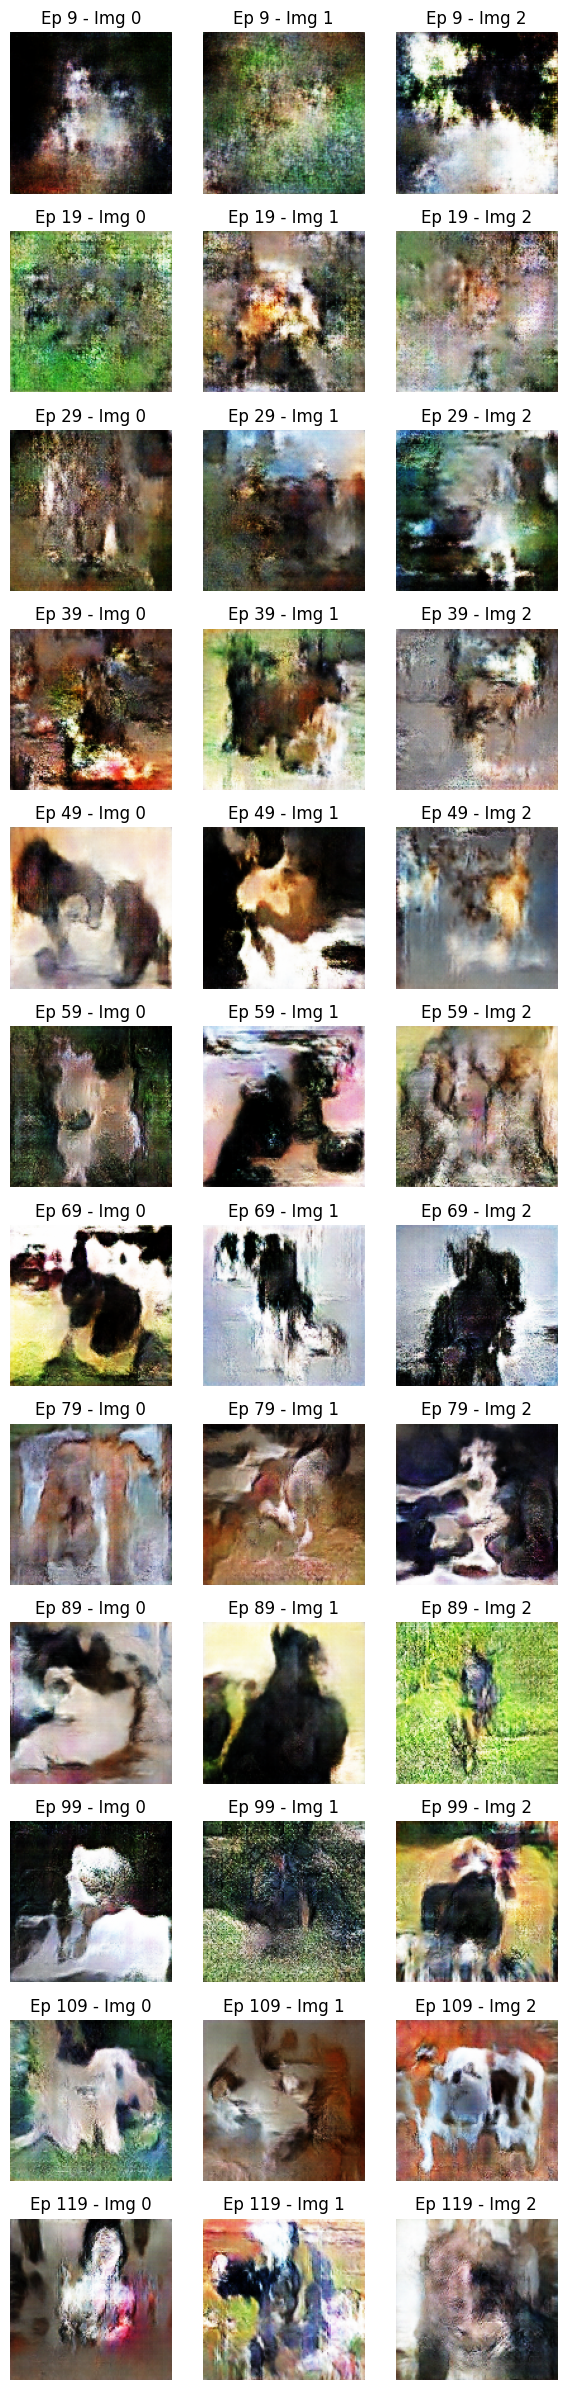

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_dir = '/content/resultados'
num_images_per_epoch = 3
epochs = range(9, 120, 10)
rows = len(epochs)
cols = num_images_per_epoch
fig, axs = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for i, epoch in enumerate(epochs):
    for j in range(num_images_per_epoch):
        img_name = f"generated_img_{epoch}_{j}.png"
        img_path = os.path.join(image_dir, img_name)

        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(f"Ep {epoch} - Img {j}")
        else:
            axs[i, j].axis('off')
            axs[i, j].set_title(f"Missing: {epoch}_{j}")

plt.tight_layout()
plt.show()

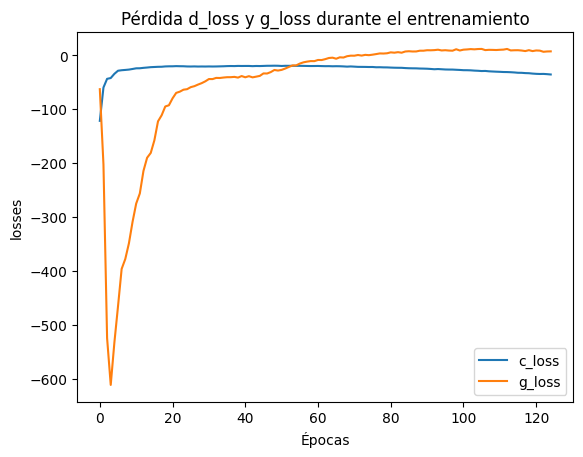

In [ ]:
import matplotlib.pyplot as plt
d_loss_values = history.history['c_loss']
g_loss_values =history.history['g_loss']
s = history.history['g_loss']
plt.plot(d_loss_values, label='c_loss')
plt.plot(g_loss_values, label='g_loss')
plt.title('Pérdida d_loss y g_loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('losses')
plt.legend()
plt.show()

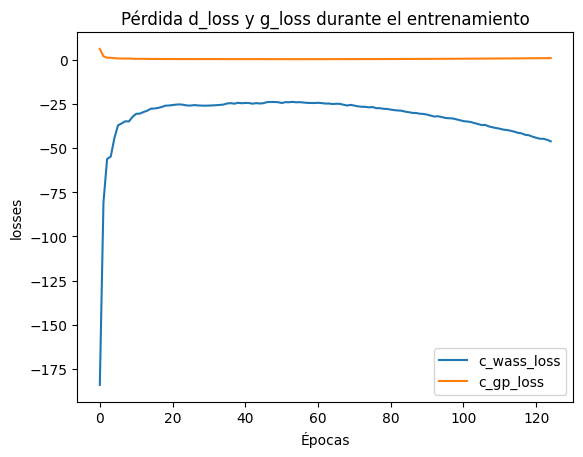

In [ ]:
import matplotlib.pyplot as plt
c_gp = history.history['c_gp']
c_wass_loss_values =history.history['c_wass_loss']
s = history.history['g_loss']
plt.plot(c_wass_loss_values, label='c_wass_loss')
plt.plot(c_gp, label='c_gp_loss')
plt.title('Pérdida d_loss y g_loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('losses')
plt.legend()
plt.show()